In [ ]:
! pip install -q kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d veeralakrishna/butterfly-dataset

 99% 451M/454M [00:06<00:00, 93.0MB/s]
100% 454M/454M [00:06<00:00, 77.1MB/s]


In [6]:
!mkdir veeralakrishna

In [7]:
! unzip butterfly-dataset.zip -d veeralakrishna

Archive:  butterfly-dataset.zip
  inflating: veeralakrishna/leedsbutterfly/README.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/001.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/002.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/003.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/004.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/005.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/006.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/007.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/008.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/009.txt  
  inflating: veeralakrishna/leedsbutterfly/descriptions/010.txt  
  inflating: veeralakrishna/leedsbutterfly/images/0010001.png  
  inflating: veeralakrishna/leedsbutterfly/images/0010002.png  
  inflating: veeralakrishna/leedsbutterfly/images/0010004.png  
  inflating: veeralakrishna/leedsbutterfly/images/0010005.pn

In [43]:
##############################################################################################
# This notebook contains Unet for image segmentation                                         #
##############################################################################################
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [44]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [45]:
# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [46]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

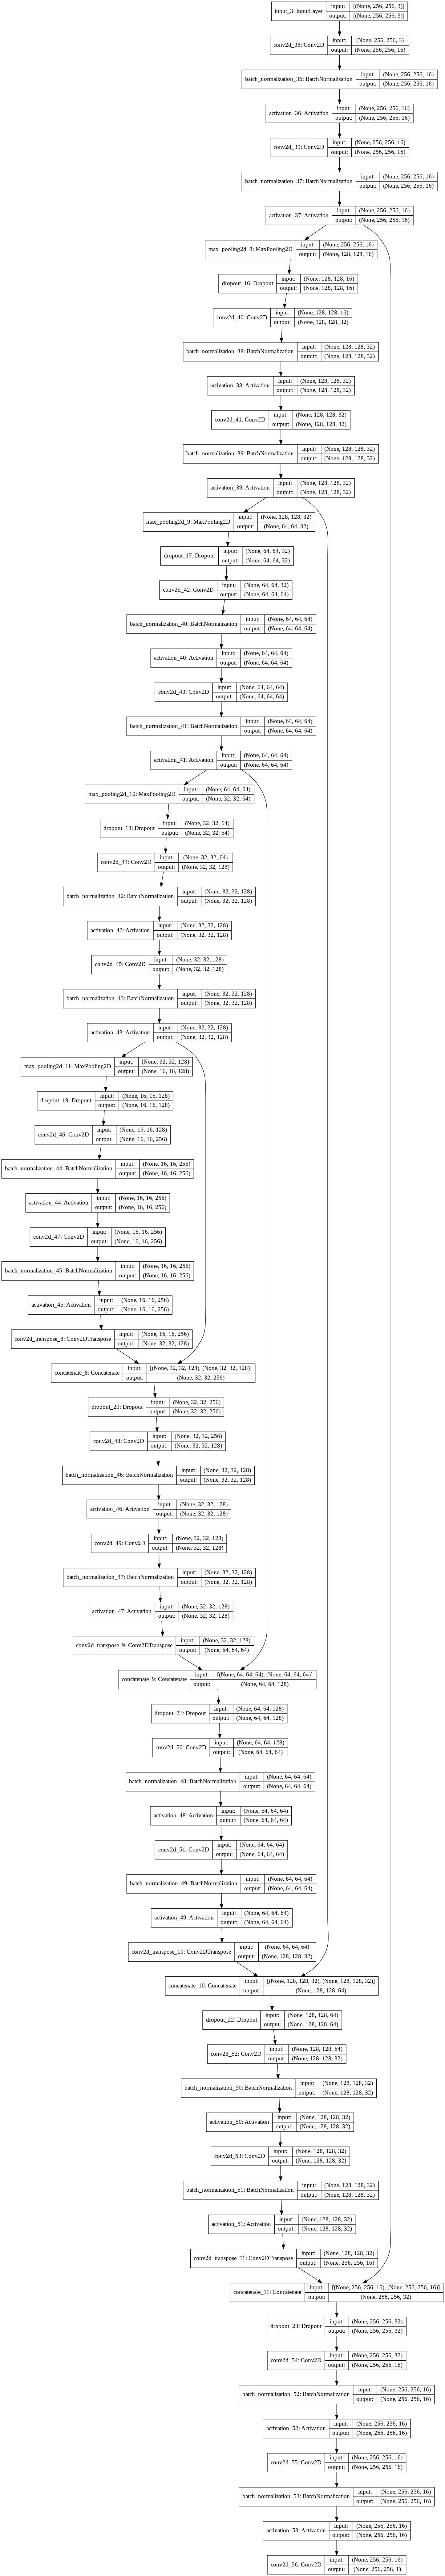

In [47]:
from keras.utils.vis_utils import plot_model
plot_model(unet, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [48]:
# defining function for dataLoading function
framObjTrain = {
    'img' : [],
    'mask' : []
  }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_seg0.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + imgNames[i]) 
            mask = plt.imread(maskAddr + maskNames[i])
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [49]:
framObjTrain = LoadData( framObjTrain, imgPath = '/content/veeralakrishna/leedsbutterfly/images', 
                        maskPath = '/content/veeralakrishna/leedsbutterfly/segmentations'
                         , shape = 256)

In [50]:
framObjTrain['img'][1]#.shape

array([[[0.21176471, 0.5764706 , 0.29803923],
        [0.20821078, 0.5764706 , 0.28737745],
        [0.21446078, 0.5764706 , 0.28296572],
        ...,
        [0.72634804, 0.594853  , 0.49264705],
        [0.708701  , 0.5878677 , 0.50661767],
        [0.6980393 , 0.58431375, 0.5137255 ]],

       [[0.20991115, 0.5764706 , 0.29247856],
        [0.20467745, 0.57311106, 0.2834966 ],
        [0.21075368, 0.5727635 , 0.2792586 ],
        ...,
        [0.7340518 , 0.5898715 , 0.48123613],
        [0.71796876, 0.58584034, 0.49312147],
        [0.707307  , 0.58060664, 0.49518996]],

       [[0.20689338, 0.5755209 , 0.284375  ],
        [0.2002159 , 0.56884336, 0.27769753],
        [0.20574209, 0.56855327, 0.27449927],
        ...,
        [0.7399165 , 0.5781107 , 0.45937836],
        [0.72905076, 0.58000207, 0.47111866],
        [0.7209712 , 0.57504594, 0.46928617]],

       ...,

       [[0.6484835 , 0.71907175, 0.77397364],
        [0.63728034, 0.69009894, 0.75253904],
        [0.5955107 , 0

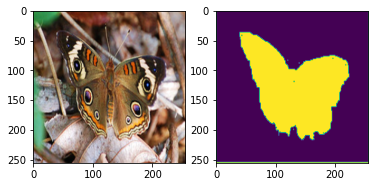

In [51]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [52]:
retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 50, verbose = 1)

Epoch 1/50
26/26 [==============================] - 12s 373ms/step - loss: 0.5478 - accuracy: 0.7191
Epoch 2/50
26/26 [==============================] - 10s 374ms/step - loss: 0.2668 - accuracy: 0.8927
Epoch 3/50
26/26 [==============================] - 10s 377ms/step - loss: 0.2173 - accuracy: 0.9063
Epoch 4/50
26/26 [==============================] - 10s 377ms/step - loss: 0.1858 - accuracy: 0.9174
Epoch 5/50
26/26 [==============================] - 10s 380ms/step - loss: 0.1580 - accuracy: 0.9288
Epoch 6/50
26/26 [==============================] - 10s 382ms/step - loss: 0.1500 - accuracy: 0.9289
Epoch 7/50
26/26 [==============================] - 10s 383ms/step - loss: 0.1360 - accuracy: 0.9356
Epoch 8/50
26/26 [==============================] - 10s 387ms/step - loss: 0.1295 - accuracy: 0.9368
Epoch 9/50
26/26 [==============================] - 10s 389ms/step - loss: 0.1127 - accuracy: 0.9438
Epoch 10/50
26/26 [==============================] - 10s 390ms/step - loss: 0.1057 - accura

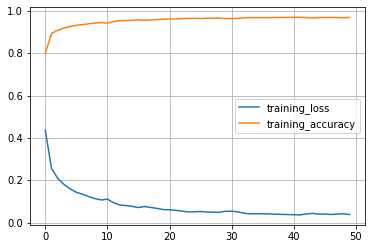

In [53]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [54]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,4,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,4,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')
    
    imh = predMask
    imh[imh < 0.5] = 0
    imh[imh > 0.5] = 1
    
    plt.subplot(1,4,4)
    plt.imshow(cv2.merge((imh, imh, imh)) * img)
    plt.title('segmented Image')

In [55]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)

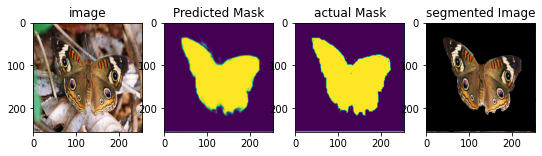

In [56]:
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

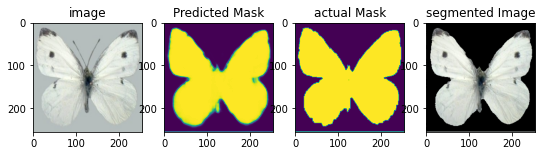

In [57]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

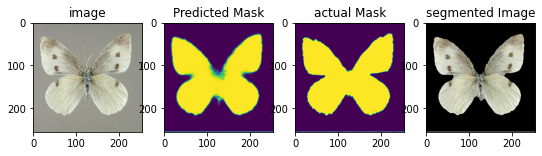

In [58]:
Plotter(actuals[4], sixteenPrediction[4][:,:,0], masks[4])

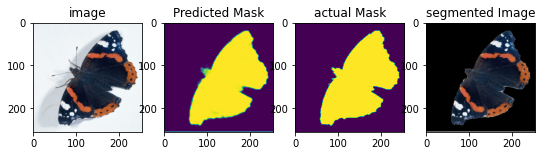

In [59]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

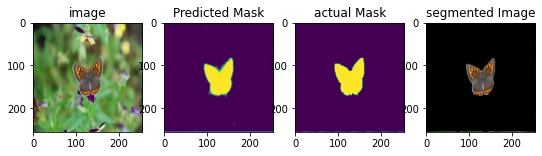

In [60]:
Plotter(actuals[15], sixteenPrediction[15][:,:,0], masks[15])

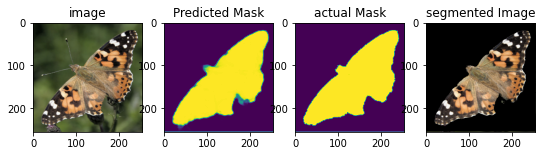

In [61]:
Plotter(actuals[8], sixteenPrediction[8][:,:,0], masks[8])

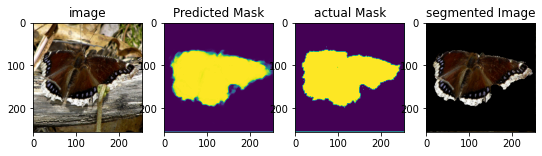

In [65]:
Plotter(actuals[12], sixteenPrediction[12][:,:,0], masks[12])

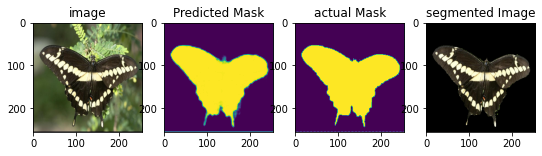

In [63]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

In [66]:
unet.save("butterfly_segmentation.h5")